In [1]:
from codes.data_utils import set_seed

import codes.Spain.data_utils_spain
import codes.Spain.preprocess_covid_spain
import importlib
import codes.data_utils

importlib.reload(codes.Spain.data_utils_spain)
importlib.reload(codes.Spain.preprocess_covid_spain)
importlib.reload(codes.data_utils)

from codes.Spain.data_utils_spain import *
from codes.Spain.preprocess_covid_spain import *
from codes.data_utils import *

In [2]:
set_seed(42)
centrality_df = pd.read_csv("data/Spain/centrality_provinces.csv")

In [3]:
mobility_df = clean_spanish_mobility_data(
    file_path="data/Spain/Spanish-Mobility-Raw.xlsx",
    centrality_path="data/Spain/centrality_provinces.csv",
    save_path="data/Spain/mobility_cleaned_final.csv"
)

cities = sorted(set(mobility_df['origin']).union(set(mobility_df['destination'])))
cities_index = {cid: i for i, cid in enumerate(cities)}
N = len(cities)
print(f"Number of Cities: {N}")

avg_matrix = pd.DataFrame(0.0, index=cities, columns=cities)
for _, row in mobility_df.iterrows():
    i, j, w = row['origin'], row['destination'], row['weight']
    avg_matrix.at[i, j] = w
    
print("Shape of avg_matrix:", avg_matrix.shape)

[✓] Final cleaned mobility data saved to: data/Spain/mobility_cleaned_final.csv
Number of Cities: 52
Shape of avg_matrix: (52, 52)


In [4]:
cities = sorted(centrality_df['nomemun'].unique())
avg_matrix = pd.DataFrame(0.0, index=cities, columns=cities)
for _, row in mobility_df.iterrows():
    i, j, w = row['PROVINCIA ORIGEN'], row['PROVINCIA DESTINO'], row['weight']
    avg_matrix.at[i, j] = w

pop_df = pd.read_csv("data/Spain/final_cleaned_population_by_province_2025.csv")
scaler = MinMaxScaler()
pop_df["Population_2025_Normalized"] = scaler.fit_transform(pop_df[["Population_2025"]])

pop_dict = dict(zip(pop_df["Province"], pop_df["Population_2025_Normalized"]))
node_pop_features = [pop_dict.get(city.title().strip(), 0.0) for city in cities]

backbone_df = extract_backbone_from_avg_matrix(avg_matrix, cities, alpha=0.01, top_k=5)
pyg_data = build_pyg_graph_from_backbone(centrality_df, backbone_df)

pyg_data.x = torch.tensor(node_pop_features).unsqueeze(1)

print(f"Backbone extracted with {len(backbone_df)} edges")
print(backbone_df.shape)
print(pyg_data)

[✓] Extracting backbone using pij < 0.01 and top-5 neighbors
[✓] Filtered down to 275 edges from 2478
[✓] Graph built with 52 nodes and 180 edges.
[✓] Converted to PyTorch Geometric format.
Backbone extracted with 275 edges
(275, 7)
Data(edge_index=[2, 360], weight=[360], edge_attr=[360, 1], num_nodes=52, x=[52, 1])


In [5]:
# Normalize edges so (A, B) and (B, A) are treated the same
normalized_edges = backbone_df.apply(
    lambda row: tuple(sorted([row['source'], row['target']])), axis=1
)

num_unique_edges = len(set(normalized_edges))
print(f"Unique undirected edges: {num_unique_edges}")

Unique undirected edges: 180


In [6]:
df_covid = pd.read_csv("data/Spain/provincias_covid19_datos_sanidad_nueva_serie.csv")
filtered_covid_df = filter_and_scale_spanish_covid_by_centrality(df_covid)

city_case_counts = filtered_covid_df['cod_ine'].value_counts().sort_index()
print(filtered_covid_df.head(100000))

[✓] Filtered to 52 provinces, 40,872 rows.
[✓] Applied Z-score normalization on daily cases (Casos).
[✓] Saved filtered + scaled Spanish COVID data to 'data/Spain/filtered_scaled_covid.csv'.
            Fecha  cod_ine         provincia  Casos  Fallecidos  \
0      2020-01-01        0         No consta      0           0   
1      2020-01-01        1       Araba/Álava      0           0   
2      2020-01-01        2          Albacete      0           0   
3      2020-01-01        3  Alicante/Alacant      0           0   
4      2020-01-01        4           Almería      0           0   
...           ...      ...               ...    ...         ...   
41652  2022-02-24       47        Valladolid      0           0   
41653  2022-02-24       48           Bizkaia     15           0   
41654  2022-02-24       49            Zamora      0           0   
41655  2022-02-24       50          Zaragoza      0           0   
41656  2022-02-24       51             Ceuta      0           0   

    

In [7]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("cpu")
    print('Using cpu')
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Using cpu


In [8]:
# Rename columns for compatibility
spain_covid_df = (
    filtered_covid_df
    .rename(columns={"cod_ine": "ibgeID", "Fecha": "date"})  # 🔁 Rename to match expected schema
)

X_train_slide, X_test_slide, Y_train_slide, Y_test_slide = generate_sliding_temporal_graph_data(
    spain_covid_df,
    input_window=14,
    output_window=1,
    feature_column="z_newCases",
    device=device,
    train_split=0.8
)

X_train_slide_gcrn, X_test_slide_gcrn, Y_train_slide_gcrn, Y_test_slide_gcrn = generate_sliding_temporal_graph_data(
    spain_covid_df,
    input_window=7,
    output_window=1,
    feature_column="z_newCases",
    device=device,
    train_split=0.8
)

[✓] Sliding window: X torch.Size([772, 14, 52, 1]), Y torch.Size([772, 1, 52, 1])
[✓] Train: torch.Size([617, 14, 52, 1]), Test: torch.Size([155, 14, 52, 1])
[✓] Sliding window: X torch.Size([779, 7, 52, 1]), Y torch.Size([779, 1, 52, 1])
[✓] Train: torch.Size([623, 7, 52, 1]), Test: torch.Size([156, 7, 52, 1])


In [9]:
import codes.models.custom_gcn_transformer_parallel
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

importlib.reload(codes.models.custom_gcn_transformer_parallel)

from codes.models.custom_gcn_transformer_parallel import SpatioTemporalFusionNet

N = pyg_data.num_nodes

model = SpatioTemporalFusionNet(
    in_channels=1,           # number of time-series features per node (e.g., newCases)
    graph_feat_dim=1,        # number of static node features (e.g., population, centrality, etc.)
    trans_hidden=1024,         # hidden dim for transformer and GCN
    out_channels=1,          # output features per node (e.g., predicting next-day cases)
    num_nodes=N              # number of nodes in the graph used for graph embeddings
).to(device)

# model.static_node_features = pyg_data.x.to(device)
# Loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.002)
# Scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.95)  # reduce LR by half every 5 epochs

In [10]:
model = SpatioTemporalFusionNet(
    in_channels=1,           # number of time-series features per node (e.g., newCases)
    graph_feat_dim=1,        # number of static node features (e.g., population, centrality, etc.)
    trans_hidden=1024,         # hidden dim for transformer and GCN
    out_channels=1,          # output features per node (e.g., predicting next-day cases)
    num_nodes=N              # number of nodes in the graph used for graph embeddings
).to(device)
model.load_state_dict(torch.load("models/Spain-Experiment-Local-Transformer-1-120-Epoch-Checkpoint.pth"))

<All keys matched successfully>

In [11]:
from torch.utils.data import Dataset, DataLoader

class CovidGraphDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [12]:
batch_size = 128  # You can tune this based on your GPU

train_dataset = CovidGraphDataset(X_train_slide, Y_train_slide)
test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [13]:
edge_index = pyg_data.edge_index.to(device)
edge_weight = pyg_data.edge_attr.view(-1).to(device)

In [14]:
num_epochs = 120
batch_size_nodes = 500  # Adjust based on GPU capability
num_nodes = N  # 5383 nodes total

In [15]:
from tqdm import tqdm
from torch_geometric.utils import subgraph

test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="🔍 Testing", leave=False)

    for batch_X, batch_Y in progress_bar:
        batch_X = batch_X.to(device)  # [B, T, N, 1]
        batch_Y = batch_Y.to(device)  # [B, N, 1]

        batch_pred = []
        batch_actual = []
        node_losses = 0.0
        num_node_batches = 0

        for node_start in range(0, num_nodes, batch_size_nodes):
            node_end = min(node_start + batch_size_nodes, num_nodes)
            node_indices = torch.arange(node_start, node_end, device=device)

            # Slice node-wise input/output
            batch_X_nodes = batch_X[:, :, node_start:node_end, :]
            batch_Y_nodes = batch_Y[:, node_start:node_end, :]

            # Slice graph edges
            edge_index_sub, edge_weight_sub = subgraph(
                node_indices, edge_index, edge_weight,
                relabel_nodes=True, num_nodes=num_nodes
            )

            # Forward pass
            output = model(batch_X_nodes, edge_index_sub, edge_weight_sub, node_indices=node_indices)

            # Fix shape mismatch for loss
            if batch_Y_nodes.dim() == 4:
                batch_Y_nodes = batch_Y_nodes.squeeze(1)  # Ensure shape [B, N, 1]

            loss = criterion(output, batch_Y_nodes)
            node_losses += loss.item()
            num_node_batches += 1

            # Store for later
            batch_pred.append(output.cpu())
            batch_actual.append(batch_Y_nodes.cpu())

        # Aggregate loss and predictions
        avg_node_loss = node_losses / num_node_batches
        test_loss += avg_node_loss

        predictions.append(torch.cat(batch_pred, dim=1))  # [B, N_chunk, 1] → [B, N, 1]
        actuals.append(torch.cat(batch_actual, dim=1))    # [B, N_chunk, 1] → [B, N, 1]

        progress_bar.set_postfix({"Loss": f"{avg_node_loss:.4f}"})

# Final aggregation
predictions = torch.cat(predictions, dim=0)  # [total_samples, N, 1]
actuals = torch.cat(actuals, dim=0)          # [total_samples, N, 1]

print(f"\n✅ Final Test Loss: {test_loss / len(test_loader):.4f}")



✅ Final Test Loss: 0.4099


In [16]:
import importlib
import codes.models.custom_gcrn
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

importlib.reload(codes.models.custom_gcrn)

from codes.models.custom_gcrn import GCRN

model = GCRN(in_channels=1, hidden_channels=512, out_channels=1).to(device)

# Loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#Scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # reduce LR by half every 5 epochs

In [17]:
model = GCRN(in_channels=1, hidden_channels=512, out_channels=1).to(device)
model.load_state_dict(torch.load("models/Spain-Experiment-GCRN-1.pth"))
model.eval()

GCRN(
  (gconv_gru): GConvGRUCell(
    (conv_z): GCNConv(513, 512)
    (conv_r): GCNConv(513, 512)
    (conv_h): GCNConv(513, 512)
  )
  (relu): ReLU()
  (linear): Linear(in_features=512, out_features=1, bias=True)
)

In [18]:
from tqdm import tqdm

test_dataset = CovidGraphDataset(X_test_slide_gcrn, Y_test_slide_gcrn)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
test_loss = 0.0
predictions_gcrn = []
actuals_gcrn = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="🔍 Testing", leave=False)

    for batch_X, batch_Y in progress_bar:
        batch_X = batch_X.to(device)  # [B, T, N, 1]
        batch_Y = batch_Y.to(device)  # [B, N, 1]
        batch_Y = batch_Y.squeeze(1)

        output = model(batch_X, edge_index, edge_weight)  # [B, N, 1]

        loss = criterion(output, batch_Y)
        test_loss += loss.item()

        # Store for plotting later
        predictions_gcrn.append(output.cpu())     # [B, N, 1]
        actuals_gcrn.append(batch_Y.cpu())        # [B, N, 1]

        progress_bar.set_postfix({"Loss": loss.item()})

# Stack everything: [B, N, 1] -> [Total_samples, N, 1]
predictions_gcrn = torch.cat(predictions_gcrn, dim=0)
actuals_gcrn = torch.cat(actuals_gcrn, dim=0)

print(f"\n✅ Final Test Loss: {test_loss / len(test_loader):.4f}")



✅ Final Test Loss: 0.5832


In [19]:
# Flatten actuals: [156, 1, 52, 1] → [156, 52]
actual_array = actuals.squeeze(1).squeeze(-1).numpy()
pred_array = predictions.squeeze(-1).numpy()  # already [156, 52]

print("Pred shape:", pred_array.shape)
print("Actual shape:", actual_array.shape)

Pred shape: (155, 52)
Actual shape: (155, 52)


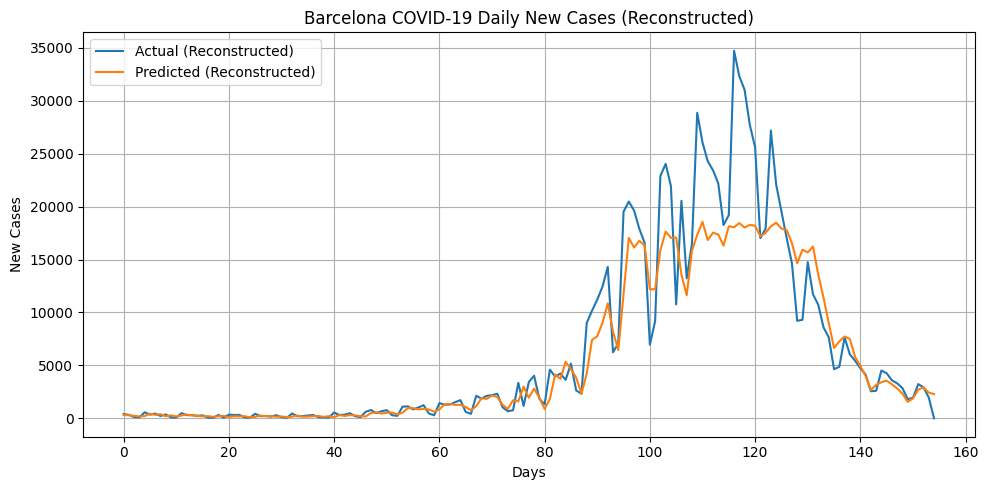

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_squared_error
import numpy as np

# Build city graph from centrality dataframe
G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_name = row['nomemun']
    G2.add_node(city_name)

# Make sure predictions and actuals are [T, N]
pred_array = predictions.squeeze(-1).numpy()        # [T, N]
actual_array = actuals.squeeze(1).squeeze(-1).numpy()  # [T, N]

# Barcelona node name
city_name = "Barcelona"
city_id_list = list(G2.nodes())
barcelona_index = city_id_list.index(city_name)

# Get z-scored predictions and actuals
barcelona_preds_z = pred_array[:, barcelona_index]
barcelona_actuals_z = actual_array[:, barcelona_index]

# 🧠 Reconstruct actual daily cases
sp_original = df_covid[df_covid['provincia'] == city_name].copy()
sp_original['Casos'] = sp_original['Casos'].clip(lower=0)
sp_original = sp_original.sort_values('Fecha')

mean_barcelona = sp_original['Casos'].mean()
std_barcelona = sp_original['Casos'].std(ddof=0)

# 🔁 De-normalize predictions
barcelona_preds = barcelona_preds_z * std_barcelona + mean_barcelona
barcelona_actuals = barcelona_actuals_z * std_barcelona + mean_barcelona

# 📈 Plot
plt.figure(figsize=(10, 5))
plt.plot(barcelona_actuals, label='Actual (Reconstructed)')
plt.plot(barcelona_preds, label='Predicted (Reconstructed)')
plt.title("Barcelona COVID-19 Daily New Cases (Reconstructed)")
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Flatten actuals: [156, 1, 52, 1] → [156, 52]
actual_array_gcrn = actuals_gcrn.squeeze(1).squeeze(-1).numpy()
pred_array_gcrn = predictions_gcrn.squeeze(-1).numpy()  # already [156, 52]

print("Pred shape:", pred_array_gcrn.shape)
print("Actual shape:", actual_array_gcrn.shape)

Pred shape: (156, 52)
Actual shape: (156, 52)


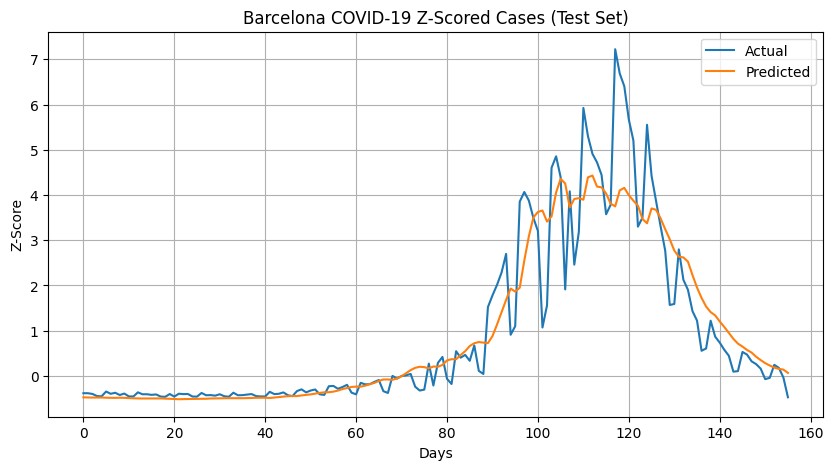

In [31]:
import matplotlib.pyplot as plt

city_name_list = list(centrality_df['nomemun'])
barcelona_index = city_name_list.index("Barcelona")

barcelona_preds = pred_array_gcrn[:, barcelona_index]
barcelona_actuals = actual_array_gcrn[:, barcelona_index]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(barcelona_actuals, label='Actual')
plt.plot(barcelona_preds, label='Predicted')
plt.title("Barcelona COVID-19 Z-Scored Cases (Test Set)")
plt.xlabel("Days")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
import codes.models.global_spatiotemporal_model
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

importlib.reload(codes.models.global_spatiotemporal_model)

from codes.models.global_spatiotemporal_model import SpatiotemporalTransformer

# Number of nodes (cities)
N = pyg_data.num_nodes

model = SpatiotemporalTransformer(
    input_dim=1,         # One feature per city per day: "newCases"
    gcn_dim=1,           # No static node features (population, centrality) passed
    hidden_dim=1024,       # Transformer + GCN hidden size
    nhead=32,             # Number of transformer heads
    num_layers=1,        # Transformer layers
    num_nodes=N,         # Number of nodes in the graph
    forecast_dim=1       # Predict one value per node (1-day ahead cases)
).to(device)
model.load_state_dict(torch.load("models/Spain-Experiment-Global-Transformer-1024-Hidden-Checkpoint-1-120-Epochs.pth"))
model.eval()

SpatiotemporalTransformer(
  (input_proj): Linear(in_features=1, out_features=1024, bias=True)
  (spatial_encoder): GCNSpatialEncoder(
    (gcn1): GCNConv(1, 1024)
    (gcn2): GCNConv(1024, 1024)
    (relu): ReLU()
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=1024, out_feature

In [25]:
from tqdm import tqdm

test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
test_loss = 0.0
predictions_global = []
actuals_global = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="🔍 Testing", leave=False)

    for batch_X, batch_Y in progress_bar:
        batch_X = batch_X.to(device)  # [B, T, N, 1]
        batch_Y = batch_Y.to(device)  # [B, N, 1]
        batch_Y = batch_Y.squeeze(1)

        output = model(batch_X, edge_index, edge_weight, node_features=pyg_data.x.to(device))  # [B, N, 1]

        loss = criterion(output, batch_Y)
        test_loss += loss.item()

        # Store for plotting later
        predictions_global.append(output.cpu())     # [B, N, 1]
        actuals_global.append(batch_Y.cpu())        # [B, N, 1]

        progress_bar.set_postfix({"Loss": loss.item()})

# Stack everything: [B, N, 1] -> [Total_samples, N, 1]
predictions_global = torch.cat(predictions_global, dim=0)
actuals_global = torch.cat(actuals_global, dim=0)

print(f"\n✅ Final Test Loss: {test_loss / len(test_loader):.4f}")


✅ Final Test Loss: 0.4691


In [26]:
# Flatten actuals: [156, 1, 52, 1] → [156, 52]
actual_array_global = actuals_global.squeeze(1).squeeze(-1).numpy()
pred_array_global = predictions_global.squeeze(-1).numpy()  # already [156, 52]

print("Pred shape:", pred_array_global.shape)
print("Actual shape:", actual_array_global.shape)

Pred shape: (155, 52)
Actual shape: (155, 52)


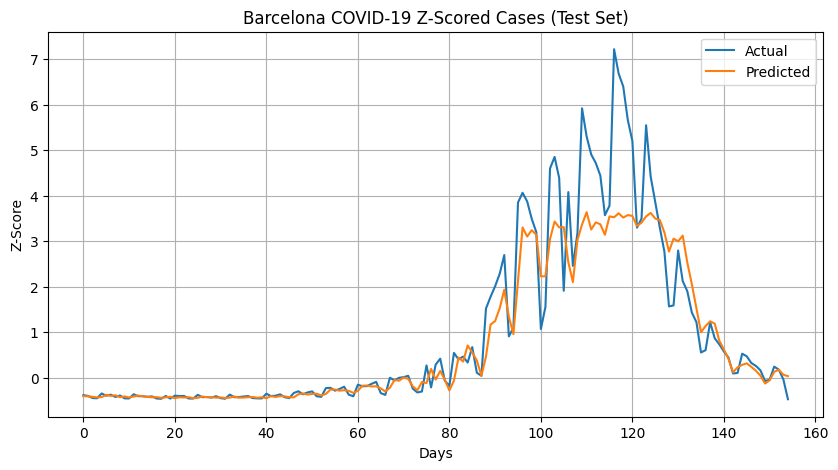

In [28]:
import matplotlib.pyplot as plt

city_name_list = list(centrality_df['nomemun'])
barcelona_index = city_name_list.index("Barcelona")

barcelona_preds = pred_array[:, barcelona_index]
barcelona_actuals = actual_array[:, barcelona_index]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(barcelona_actuals, label='Actual')
plt.plot(barcelona_preds, label='Predicted')
plt.title("Barcelona COVID-19 Z-Scored Cases (Test Set)")
plt.xlabel("Days")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.show()

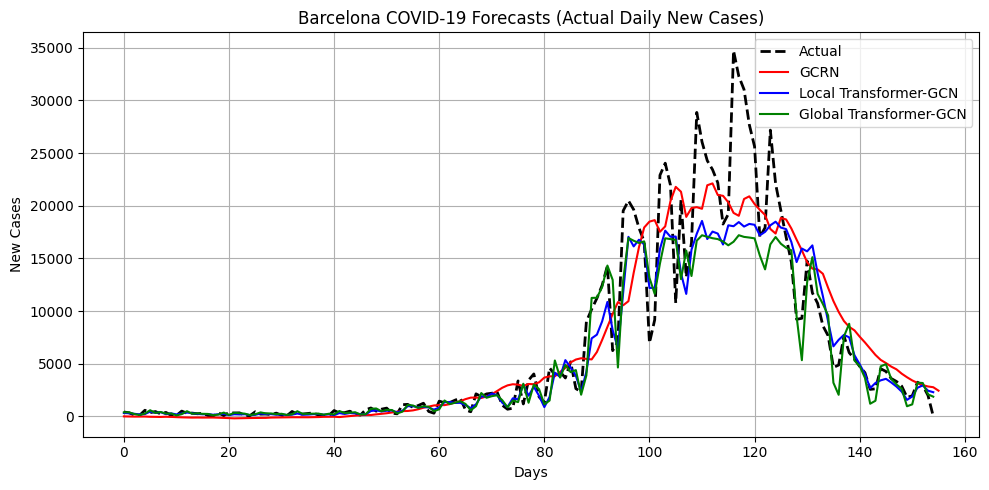

In [35]:
import matplotlib.pyplot as plt

# Get index for Barcelona
city_name_list = list(centrality_df['nomemun'])
barcelona_index = city_name_list.index("Barcelona")

# Z-scored predictions and actuals
barcelona_actuals_z = actual_array[:, barcelona_index]
barcelona_gcrn_preds_z = pred_array_gcrn[:, barcelona_index]
barcelona_local_preds_z = pred_array[:, barcelona_index]
barcelona_global_preds_z = pred_array_global[:, barcelona_index]  

# Inverse Z-score normalization
barcelona_actuals = barcelona_actuals_z * std_barcelona + mean_barcelona
barcelona_gcrn_preds = barcelona_gcrn_preds_z * std_barcelona + mean_barcelona
barcelona_local_preds = barcelona_local_preds_z * std_barcelona + mean_barcelona
barcelona_global_preds = barcelona_global_preds_z * std_barcelona + mean_barcelona

# Plot reconstructed
plt.figure(figsize=(10, 5))
plt.plot(barcelona_actuals, label='Actual', color='black', linestyle='--', linewidth=2)
plt.plot(barcelona_gcrn_preds, label='GCRN', color='red')
plt.plot(barcelona_local_preds, label='Local Transformer-GCN', color='blue')
plt.plot(barcelona_global_preds, label='Global Transformer-GCN', color='green')

plt.title("Barcelona COVID-19 Forecasts (Actual Daily New Cases)")
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/barcelona_all_models_actual_comparison.png", dpi=300)
plt.show()
